# Capstone Project - Party or Study:  What clustering can tell us about university culture

---
## Author: Jabe Hickey
---
### Code for project
I started by importing the libraries needed to do the analysis

In [227]:
# import libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import urllib3
from bs4 import BeautifulSoup #to scrape web site for data
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
#!pip install --user folium 
import folium # plotting library



I downloaded a .csv file from the [National Center for Educational Statistics](https://nces.ed.gov/) and uploaded it into the Watson Studio and into a dataframe in this notebook to do the analysis.

In [228]:
# The code was removed by Watson Studio for sharing.

,unitid,institution name,year,institution name.1,HD2017.Institution name alias,HD2017.Street address or post office box,HD2017.City location of institution,HD2017.State abbreviation,HD2017.ZIP code,HD2017.Level of institution,HD2017.Longitude location of institution,HD2017.Latitude location of institution,HD2017.Postsecondary and Title IV institution indicator,HD2017.Institutional category
0,100663,University of Alabama at Birmingham,2017,University of Alabama at Birmingham,NaN,Administration Bldg Suite 1070,Birmingham,Alabama,35294-0110,Four or more years,-86.799345,33.505697,Title IV postsecondary institution,"Degree-granting, primarily baccalaureate or above"
1,100751,The University of Alabama,2017,The University of Alabama,NaN,739 University Blvd,Tuscaloosa,Alabama,35487-0166,Four or more years,-87.545978,33.211875,Title IV postsecondary institution,"Degree-granting, primarily baccalaureate or above"
2,100858,Auburn University,2017,Auburn University,NaN,NaN,Auburn,Alabama,36849,Four or more years,-85.488258,32.599378,Title IV postsecondary institution,"Degree-granting, primarily baccalaureate or above"
3,104151,Arizona State University-Tempe,2017,Arizona State University-Tempe,"ASU Tempe, ASU Main",University Drive and Mill Avenue,Tempe,Arizona,85287,Four or more years,-111.934383,33.417721,Title IV postsecondary institution,"Degree-granting, primarily baccalaureate or above"
4,104179,University of Arizona,2017,University of Arizona,UA|U of A|Arizona|UofA|The University of Arizo...,1401 E University,Tucson,Arizona,85721-0066,Four or more years,-110.950815,32.232672,Title IV postsecondary institution,"Degree-granting, primarily baccalaureate or above"


I then cleaned up the data so that it only contained the data I needed.  This also included getting a random sample of 50 universities instead of the entire data set.

In [229]:
#copy the columns of data that are needed to a new dataframe and select a random sample of 50 for the analysis
df_universities = df_rawdata[['institution name','HD2017.Longitude location of institution', 'HD2017.Latitude location of institution','HD2017.City location of institution']].sample(n=50)

df_universities.columns=['university','longitude','latitude','city']
df_universities = df_universities.sort_values(axis=0, by=['university'],ascending=True)
df_universities.head()

,university,longitude,latitude,city
71,Boston University,-71.107942,42.351118,Boston
14,California State University-Los Angeles,-118.168965,34.066927,Los Angeles
123,Clemson University,-82.835114,34.679381,Clemson
31,Colorado State University-Fort Collins,-105.080732,40.574805,Fort Collins
162,Columbia Southern University,-87.653162,30.329288,Orange Beach


I then inspected the data to look at how much there was, what the data types looked like and if there was any missing data.  The data was very high quality and did not have any missing data.

In [230]:
df_universities.shape

(50, 4)

In [231]:
df_universities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 71 to 149
Data columns (total 4 columns):
university    50 non-null object
longitude     50 non-null float64
latitude      50 non-null float64
city          50 non-null object
dtypes: float64(2), object(2)
memory usage: 2.0+ KB


I created an initial map of the universities to ensure that the longitude and latitude worked and I could get them to display correctly.

In [255]:
# create map of the Universities using latitude and longitude values

address = 'United States'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_university = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, university in zip(df_universities['latitude'], df_universities['longitude'], df_universities['university']):
    label = '{}'.format(university)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_university)
    
map_university

The next thing I did was to get the types of venues that were within 1500 meters of each university from the Foursquare API .

In [233]:
CLIENT_ID = 'AHMH5GZ0BOPDZ4J0FAE3JO1IXGRSBPK5UATETXQLSGUADNYS' # your Foursquare ID
CLIENT_SECRET = 'ZXSGSRLTDE1U1V5ZCIOXWP2ASOJL5IEWSDZ04DWCRROXYZXK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300

def getNearbyVenues(names, latitudes, longitudes, radius=1600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['university', 
                  'university Latitude', 
                  'university Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
university_venues = getNearbyVenues(names=df_universities['university'], latitudes=df_universities['latitude'], longitudes=df_universities['longitude'], radius=1600)

Boston University
California State University-Los Angeles
Clemson University
Colorado State University-Fort Collins
Columbia Southern University
Cornell University
DePaul University
Excelsior College
Florida International University
Florida State University
George Mason University
George Washington University
Georgia Southern University
Illinois State University
Indiana University-Bloomington
Kaplan University-Davenport Campus
Mississippi State University
Missouri State University-Springfield
North Carolina State University at Raleigh
Northern Arizona University
Nova Southeastern University
Ohio State University-Main Campus
Ohio University-Main Campus
Old Dominion University
Portland State University
San Jose State University
Southern New Hampshire University
Temple University
Texas State University
Towson University
University at Buffalo
University of Akron Main Campus
University of Arizona
University of Cincinnati-Main Campus
University of Colorado Denver/Anschutz Medical Campus
Univ

I cut the venues down to bars ("Party") or coffee shops ("Study")

In [234]:
bars_or_coffee= university_venues.loc[(university_venues['Venue Category'].isin(['Bar','Coffee Shop']))]
bars_or_coffee.head()

,university,university Latitude,university Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
46,Boston University,42.351118,-71.107942,Pavement Coffeehouse,42.344178,-71.098410,Coffee Shop
60,Boston University,42.351118,-71.107942,Starbucks,42.350691,-71.114521,Coffee Shop
77,Boston University,42.351118,-71.107942,The Lower Depths,42.348739,-71.093832,Bar
78,Boston University,42.351118,-71.107942,Blue State Coffee,42.351671,-71.118881,Coffee Shop
136,Clemson University,34.679381,-82.835114,"""All In"" Coffee Shop",34.683678,-82.836407,Coffee Shop


The following cell shows me the number of venues for all of the universities and the number per university.

In [235]:
print('The total number of venues for all of the universities is ',bars_or_coffee.shape[0])

how_many_venues=bars_or_coffee.groupby('university').count()
how_many_venues=how_many_venues.loc[:, ['Venue Category']]
how_many_venues.rename(columns={'Venue Category':'Venue Count'},inplace=True)
how_many_venues.reset_index(inplace=True)
how_many_venues.head()

The total number of venues for all of the universities is  328


,university,Venue Count
0,Boston University,4
1,Clemson University,6
2,Colorado State University-Fort Collins,15
3,Cornell University,6
4,DePaul University,6


I then prepared the data for a kmeans clustering analysis by performing one hot coding.

In [236]:
# one hot encoding
bars_or_coffee_onehot = pd.get_dummies(bars_or_coffee[['Venue Category']], prefix="", prefix_sep="")

# add university column back to dataframe
bars_or_coffee_onehot['university'] = bars_or_coffee['university'] 

# move neighborhood column to the first column
fixed_columns = [bars_or_coffee_onehot.columns[-1]] + list(bars_or_coffee_onehot.columns[:-1])
bars_or_coffee_onehot = bars_or_coffee_onehot[fixed_columns]

bars_or_coffee_onehot.head()

,university,Bar,Coffee Shop
46,Boston University,0,1
60,Boston University,0,1
77,Boston University,1,0
78,Boston University,0,1
136,Clemson University,0,1


The next thing I did was look at what the ratio of bars to coffee shops were for each university.

In [237]:
bars_or_coffee_freq = bars_or_coffee_onehot.groupby('university').mean().reset_index()
num_top_venues = 2

for uni in bars_or_coffee_freq['university']:
    print("----"+uni+"----")
    temp = bars_or_coffee_freq[bars_or_coffee_freq['university'] == uni].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')



----Boston University----
         venue  freq
0  Coffee Shop  0.75
1          Bar  0.25


----Clemson University----
         venue  freq
0          Bar   0.5
1  Coffee Shop   0.5


----Colorado State University-Fort Collins----
         venue  freq
0  Coffee Shop   0.8
1          Bar   0.2


----Cornell University----
         venue  freq
0  Coffee Shop  0.83
1          Bar  0.17


----DePaul University----
         venue  freq
0  Coffee Shop  0.83
1          Bar  0.17


----Florida International University----
         venue  freq
0  Coffee Shop   0.8
1          Bar   0.2


----Florida State University----
         venue  freq
0          Bar   0.5
1  Coffee Shop   0.5


----George Mason University----
         venue  freq
0  Coffee Shop   1.0
1          Bar   0.0


----George Washington University----
         venue  freq
0  Coffee Shop   1.0
1          Bar   0.0


----Georgia Southern University----
         venue  freq
0  Coffee Shop   1.0
1          Bar   0.0


----Illinois State

In [238]:
bars_or_coffee_freq.head()

,university,Bar,Coffee Shop
0,Boston University,0.250000,0.750000
1,Clemson University,0.500000,0.500000
2,Colorado State University-Fort Collins,0.200000,0.800000
3,Cornell University,0.166667,0.833333
4,DePaul University,0.166667,0.833333


I then performed a kmeans clustering analysis using 2 clusters.  

In [239]:
# set number of clusters
kclusters = 2

bars_or_coffee_clustering = bars_or_coffee_freq.drop('university', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0,init='k-means++', n_init=4, max_iter=10).fit(bars_or_coffee_clustering)

# fix index
university_merged = df_universities
university_merged.index = range(len(university_merged))

# add clustering labels
bars_or_coffee_freq['Cluster Labels'] = pd.Series(kmeans.labels_)

bars_or_coffee_freq.head()


,university,Bar,Coffee Shop,Cluster Labels
0,Boston University,0.250000,0.750000,1
1,Clemson University,0.500000,0.500000,0
2,Colorado State University-Fort Collins,0.200000,0.800000,1
3,Cornell University,0.166667,0.833333,1
4,DePaul University,0.166667,0.833333,1


I did some analysis to get an understanding of what the clusters meant.  The first analysis was to figure out how many universities were in each cluster

In [240]:
bars_or_coffee_freq.groupby('Cluster Labels').count()

,university,Bar,Coffee Shop
Cluster Labels,,,
0,17,17,17
1,29,29,29


In the next analysis I compared how the percentage of bars vs coffee shops in each cluster.  You can see that there a very distinct difference between the percentage of bars in each cluster.  The cluster with the significantly lower percentage of bars represents the study schools.  The cluster with the higher percentage of bars is the party school. For this sample, cluster 1 is the cluster of study schools and cluster 0 is the party schools.

In [241]:
bars_or_coffee_freq.groupby('Cluster Labels').mean()

,Bar,Coffee Shop
Cluster Labels,,
0,0.565491,0.434509
1,0.166256,0.833744


I wanted to do a visualization of the clusters that showed how many bars and coffee shops surrounded them.  So the first thing I did was create a dataframe with the number or bars and coffee shops and the name and cluster number of the university

In [242]:
bars_or_coffee_num=bars_or_coffee_onehot.groupby('university').sum()
bars_or_coffee_freq = bars_or_coffee_freq.reset_index(drop=False)
bars_or_coffee_num = bars_or_coffee_num.reset_index(drop=False)
bars_or_coffee_num['Cluster Labels'] = bars_or_coffee_freq['Cluster Labels']
bars_or_coffee_num.head()

,university,Bar,Coffee Shop,Cluster Labels
0,Boston University,1,3,1
1,Clemson University,3,3,0
2,Colorado State University-Fort Collins,3,12,1
3,Cornell University,1,5,1
4,DePaul University,1,5,1


Then I created a scatter plot to show the 2 clusters.

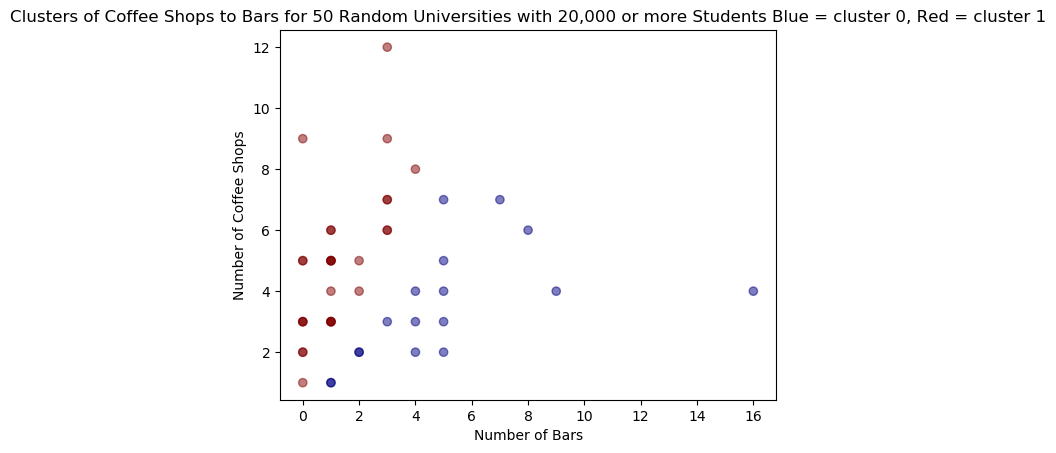

In [243]:
plt.set_cmap('jet')
plt.scatter(bars_or_coffee_num['Bar'], bars_or_coffee_num['Coffee Shop'], marker='o', c=bars_or_coffee_num['Cluster Labels'], alpha=0.5)
plt.xlabel('Number of Bars') # add to x-
plt.xlabel('Number of Bars') # add to x-
plt.ylabel('Number of Coffee Shops') # add y-label to the plot
plt.title('Clusters of Coffee Shops to Bars for 50 Random Universities with 20,000 or more Students Blue = cluster 0, Red = cluster 1') # add title to the plot
plt.show()

I wanted to see the universities on a map with their clusters.  I had to add clusters to university longitude and latitude

In [264]:
# create a data frame to show universities need to add longitude and latritude for it to display.
university_merged = df_universities
university_merged.index = range(len(university_merged))

# add clustering labels
university_merged['Cluster Labels'] = bars_or_coffee_num['Cluster Labels']
university_merged.dropna(axis=0,inplace=True) # i have to drop any locations that don't have any venues to display correctly in map
university_merged.head()

,university,longitude,latitude,city,Cluster Labels
0,Boston University,-71.107942,42.351118,Boston,1
1,California State University-Los Angeles,-118.168965,34.066927,Los Angeles,0
2,Clemson University,-82.835114,34.679381,Clemson,1
3,Colorado State University-Fort Collins,-105.080732,40.574805,Fort Collins,1
4,Columbia Southern University,-87.653162,30.329288,Orange Beach,1


In [262]:
#map the clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, city in zip(university_merged['latitude'], university_merged['longitude'], university_merged['university'], university_merged['Cluster Labels'], university_merged['city']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup(str(poi) + ' Location: ' + str(city) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Finally I looked at the schools in each cluster to see which schools were party schools vs study schools.  Cluster 0 was my party school for this run.

In [245]:
#schools in cluster 0
bars_or_coffee_num.loc[bars_or_coffee_num['Cluster Labels'] == 0]

,university,Bar,Coffee Shop,Cluster Labels
1,Clemson University,3,3,0
6,Florida State University,4,4,0
10,Illinois State University,2,2,0
11,Indiana University-Bloomington,8,6,0
12,Kaplan University-Davenport Campus,1,1,0
14,Missouri State University-Springfield,7,7,0
17,Nova Southeastern University,2,2,0
18,Ohio State University-Main Campus,9,4,0
24,Texas State University,5,3,0
25,Towson University,4,2,0


Cluster 1 was my study school for this sample of schools.

In [246]:
#schools in cluster 
bars_or_coffee_num.loc[bars_or_coffee_num['Cluster Labels'] == 1]

,university,Bar,Coffee Shop,Cluster Labels
0,Boston University,1,3,1
2,Colorado State University-Fort Collins,3,12,1
3,Cornell University,1,5,1
4,DePaul University,1,5,1
5,Florida International University,1,4,1
7,George Mason University,0,3,1
8,George Washington University,0,5,1
9,Georgia Southern University,0,2,1
13,Mississippi State University,0,3,1
15,North Carolina State University at Raleigh,1,6,1
